In [1]:
import numpy as np
import scipy
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
from tqdm import tqdm
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import math
import nltk
import pyLDAvis
import pyLDAvis.sklearn as LDAsklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF, SparsePCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn import metrics
import xml.etree.ElementTree as etree
import time
import spacy
from spacy import displacy
from wordcloud import WordCloud

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [246]:
class Model:
    def __init__(self, y_train, y_test):
        self.models = pd.DataFrame(columns=[
            'name',
            'grid_params',
            'best_params',
            'data_use',
            'model',
            'error',
            'Precision',
            'Recall',
            'F_mesure',
            'proportion_de_prédiction',
            'auc_micro',
            'auc_macro',
            'y_pred',
            'params'
        ])
        self.y_train = y_train
        self.y_test = y_test
        self.x = {}
    def add_model(self, name, model, params=None):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models = self.models.append({
            'name': name,
            'grid_params': params,
            'model': model
        }, ignore_index=True)
    def add_prediction(self, name, y_pred):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models = self.models.append({
            'name': name,
            'y_pred': y_pred
        }, ignore_index=True)
    def add_data(self, data_name, x_train, x_test):
        self.x[data_name] = {
            'x_train': x_train,
            'x_test': x_test
        }
    def fit(self, name='all', data_name=None, cv=None):
        if name == 'all':
            self.models.apply(lambda x: self._fit_process(x, data_name, cv), axis=1)
        elif type(name) == str:
            self._fit_process(self.models[self.models['name'] == name], data_name, cv)
        elif type(name) == list:
            for model_name in name:
                self._fit_process(self.models[self.models['name'] == model_name], data_name, cv)
    def _fit_process(self, model, data_name, cv):
        if data_name == None:
            data_name = list(self.x.keys())[-1]
        x_train = self.x[data_name]['x_train']
        x_test = self.x[data_name]['x_test']
        if model['grid_params'] != None:
            grid = GridSearchCV(model['model'], model['grid_params'], n_jobs=-1, cv=cv)
            grid.fit(x_train, self.y_train)
            model['model'] = grid.best_estimator_
        model['model'].fit(x_train, self.y_train)
        print('le model '+model['name']+' à fini son entrainement')
        model['best_params'] = model['model'].get_params()
        model['data_use'] = data_name
        y_pred = model['model'].predict_proba(x_test)
        model['y_pred'] = y_pred
        self.compute_perf(model['name'])
        print('tout est bon pour le model '+model['name'])
    def compute_perf(self, model_name: str, tags_num='origin'):
        model = self.models.loc[self.models[self.models['name'] == model_name].index[0]]
        y_true = self.y_test
        y_pred = model['y_pred']
        n_classes = y_true.shape[1]
        n_indiv = y_true.shape[0]
        if tags_num == 'origin':
            tags_num = y_true.sum()/n_indiv
        i = 0.5
        seuil = 1
        while i > 0.005 :
            if (y_pred >= seuil).sum()/n_indiv < tags_num :
                seuil -= i
            else :
                seuil += i
            i /= 2
        y_predict = y_pred >= seuil
        mcm = multilabel_confusion_matrix(y_true, y_predict)
        tn = mcm[:, 0, 0].mean()
        tp = mcm[:, 1, 1].mean()
        fn = mcm[:, 1, 0].mean()
        fp = mcm[:, 0, 1].mean()
        model['error'] = (fp+fn)/(tn+tp+fp+fn)
        model['Precision'] = tp/(tp+fp)
        model['Recall'] = tp/(tp+fn)
        model['F_mesure'] = (2*tp)/(2*tp+fp+fn)
        model['proportion_de_prédiction'] = (tp + fp)/(tp + fn)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
            if y_true[:, i].sum() == 0:
                tpr[i] = fpr[i]
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes
            
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        model['auc_micro'] = roc_auc["micro"]
        model['auc_macro'] = roc_auc["macro"]
        model['params'] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
        print(model)
    def plot_roc(self, name):
        model = self.models.loc[self.models[self.models['name'] == name].index[0]]
        fpr = model['params']['fpr']
        tpr = model['params']['tpr']
        roc_auc = model['params']['roc_auc']
        
        plt.figure(figsize=(15, 15))
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
        )
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()

In [6]:
def plot_top_words(model, feature_names, n_top_words, nb_line_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_line_plot)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_line_plot*6):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Préparation

In [7]:
post = pd.read_csv('Data/Posts_Clean_1.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
vocabulary = np.load('Data/Vocabulary.npy', allow_pickle=True)
post = post.sample(n=10000)

In [8]:
X = post["Text"].values
Y = post["Tags_list"].str.split().values
x_train, x_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=9000)

In [9]:
tags_binarizer = MultiLabelBinarizer()
tags_binarizer.fit(y_train)
y_train = tags_binarizer.transform(y_train)
y_test = tags_binarizer.transform(y_test)

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", vocabulary=vocabulary)
count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tf_idn = TfidfTransformer()
tf_idn.fit(x_train_counts)
x_train_tfidf = tf_idn.transform(x_train_counts)
x_test_tfidf = tf_idn.transform(x_test_counts)

## Supervisée

In [30]:
tSVD = TruncatedSVD(n_components=300)
tSVD.fit(x_train_tfidf)
x_train_Tsvd = tSVD.transform(x_train_tfidf)
x_test_Tsvd = tSVD.transform(x_test_tfidf)

In [140]:
acp = PCA(n_components=300)
acp.fit(x_train_tfidf)
x_train_acp = acp.transform(x_train_tfidf)
x_test_acp = acp.transform(x_test_tfidf)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [87]:
lda = LatentDirichletAllocation(
    n_components=30, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=30, n_jobs=-1)

In [88]:
x_train_lda = lda.transform(x_train_counts)

In [102]:
np.concatenate((x_test_tfidf, x_train_lda), axis=1).shape

ValueError: zero-dimensional arrays cannot be concatenated

In [1]:
x_train_counts

NameError: name 'x_train_counts' is not defined

In [35]:
model = Model(y_train=y_train, y_test=y_test)
model.add_data(data_name='tf-idf', x_train=x_train_tfidf, x_test=x_test_tfidf)

In [36]:
forest = RandomForestClassifier(n_jobs=-1)
model.add_model('forest', forest)

In [37]:
model.fit()

le model forest à fini son entrainement
tout est bon pour le model forest


In [16]:
model.models

name grid_params                                        best_params  \
0  forest        None  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   

  data_use                                              model     error  \
0   tf-idf  (DecisionTreeClassifier(max_features='auto', r...  0.013415   

  Precision    Recall  F_mesure proportion_de_prédiction auc_micro auc_macro  \
0  0.881303  0.246113  0.384774                 0.279261  0.945679  0.903801   

                                              params  
0  {'fpr': {0: [0.0, 0.0, 0.0, 0.0010030090270812...

In [190]:
test.apply(lambda x: print(x), axis=1)

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

0    None
1    None
dtype: object

In [188]:
for lop in range(test.shape[1]):
    test.iloc
test.apply(lambda x: print(x))

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

In [142]:
test = pd.DataFrame({'name': 'forest', 'model': forest})

In [147]:
test['model'].apply(lambda x: x.predict(x_test_tfidf))

0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
11    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
12    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
14    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
15    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
16    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
17    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [192]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(x_train_tfidf, y_train)
Y_Pred = forest.predict(x_test_tfidf)

In [212]:
Y_Proba = np.array(Y_Prob)[:,:,1].T

(2000, 100)

In [211]:
Y_Proba.shape

(2000, 100)

In [213]:
y_test.shape

(2000, 100)

In [193]:
Y_Prob = forest.predict_proba(x_test_tfidf)
Y_Proba = []
for i in Y_Prob:
    Y_Proba.append(i[:,0])
Y_Proba = 1 - np.array(Y_Proba).T

In [137]:
n_classes = y_train.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_Proba[:, i])
    if y_test[:, i].sum() == 0:
        tpr[i] = fpr[i]
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [138]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

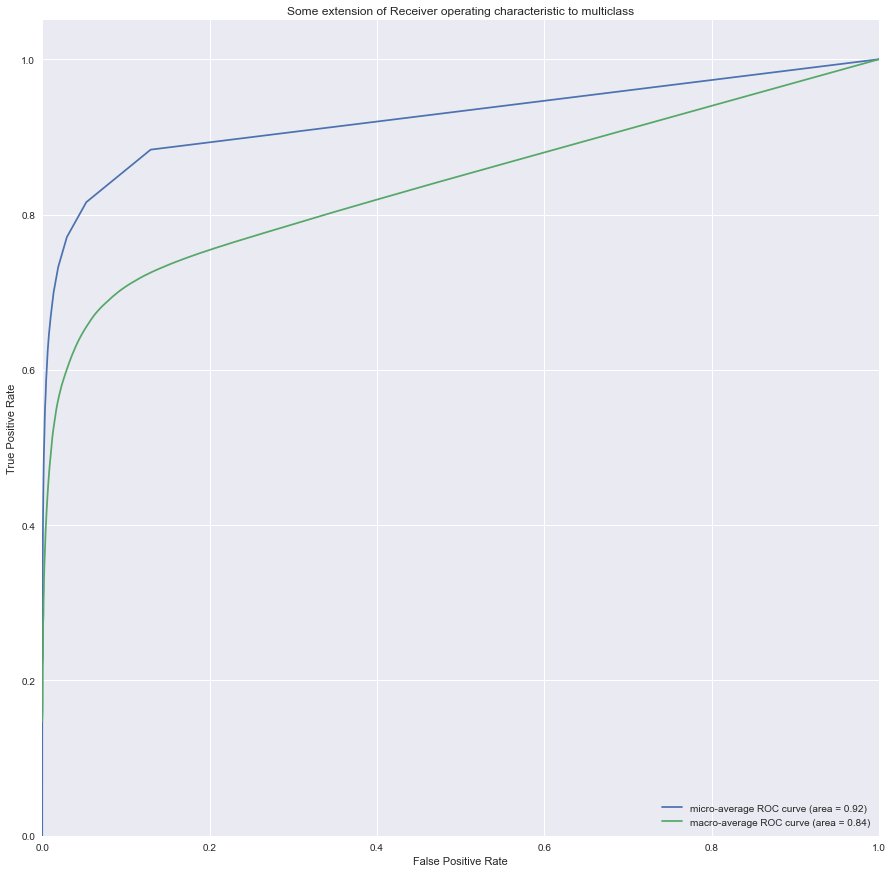

In [156]:
# Plot all ROC curves

plt.figure(figsize=[15,15])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

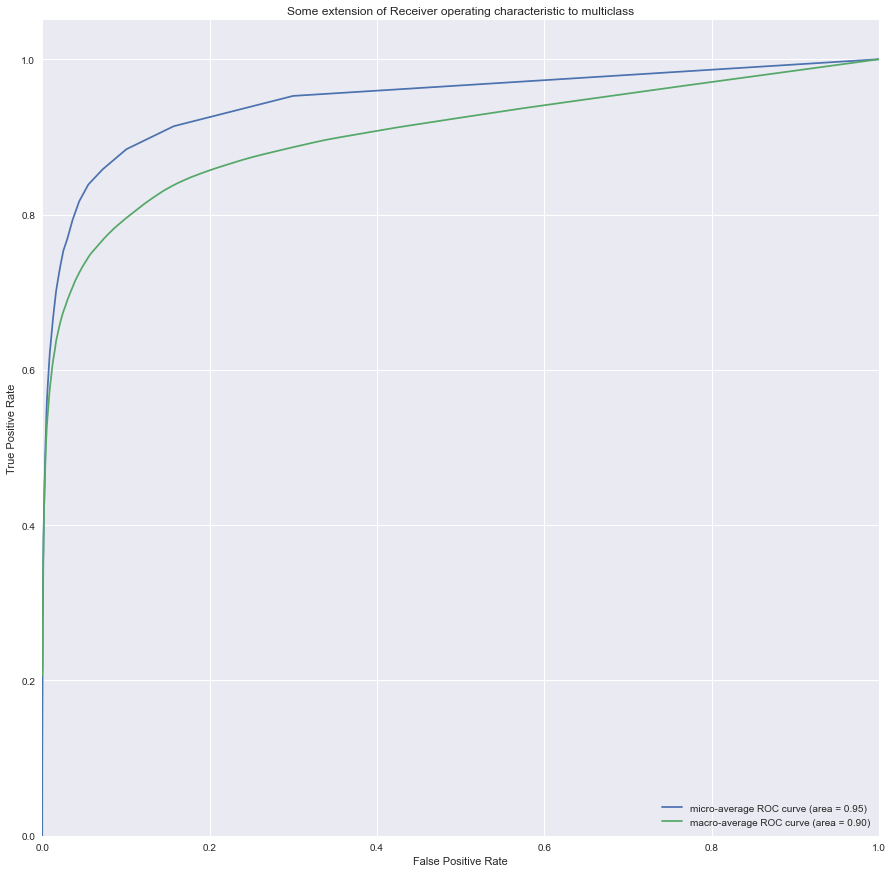

In [38]:
model.plot_roc('forest')

In [83]:
i = 0.5
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()
while (tp + fp) < (tp + fn):
    Y_Est = Y_Proba > i
    mcm = multilabel_confusion_matrix(y_test, Y_Est)
    tn = mcm[:, 0, 0].mean()
    tp = mcm[:, 1, 1].mean()
    fn = mcm[:, 1, 0].mean()
    fp = mcm[:, 0, 1].mean()
    i -= 0.001
print(i)

0.13899999999999968


In [76]:
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()

In [86]:
[[tn,fn], [fp, tp]]

[[1984.695652173913, 4.785024154589372],
 [5.345410628019324, 5.173913043478261]]

In [84]:
(tp + fp)/(tp + fn)

10.519323671497585

In [85]:
tp + fn

9.958937198067634

## Non-Supervisée

### LDA Gensim

In [10]:
texts = count_vect.inverse_transform(x_train_counts)
dico = Dictionary(texts)
corpus = [dico.doc2bow(text) for text in texts]

In [11]:
texts_test = count_vect.inverse_transform(x_test_counts)
corpus_test = [dico.doc2bow(text) for text in texts_test]

In [41]:
# Build LDA model
lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=20,
                                  random_state=100,
                                  per_word_topics=True)
# Print Perplexity score
print('Perplexity: ', lda.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=texts, 
                                     dictionary=dico, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.673216794720915
Coherence Score:  0.33685801400524856


Text(0, 0.5, "Temps d'execution")

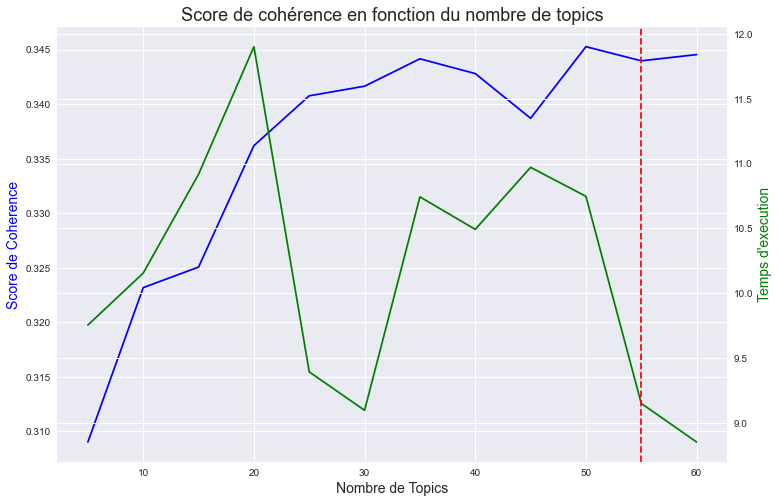

In [43]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(params, coherence_score, color="b")
ax2.plot(params, time_fit, color="g")
plt.axvline(55, color="r", linestyle='--', label="Le meileur paramètre est : 20")
plt.title("Score de cohérence en fonction du nombre de topics", fontsize=18)
ax1.set_xlabel("Nombre de Topics", fontsize=14)
ax1.set_ylabel("Score de Coherence", fontsize=14, color="b")
ax2.set_ylabel("Temps d'execution", fontsize=14, color="g")

In [12]:
best_lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=55)

In [13]:
ldaTags_gensim = np.vectorize(lambda x: dico.get(x))(best_lda.get_topics().argmax(axis=1))

In [14]:
topics_gensim = np.array(best_lda.get_document_topics(corpus, minimum_probability=0))[:,:,1]

In [167]:
topics_gensim.T.shape

(55, 8000)

In [169]:
y_train.shape

(8000, 100)

In [186]:
topic_matrice = np.matmul(topics_gensim.T, y_train)
topic_matrice = topic_matrice.T/topic_matrice.sum(axis=1)
topic_matrice.shape

(100, 55)

In [198]:
topic_matrice[:,0].sum()

1.0

In [16]:
score = np.matmul(np.array(best_lda.get_document_topics(corpus_test, minimum_probability=0))[:,:,1], topic_matrice)

In [247]:
model = Model(y_train=y_train, y_test=y_test)

In [248]:
model.add_prediction('lda gensim', score)

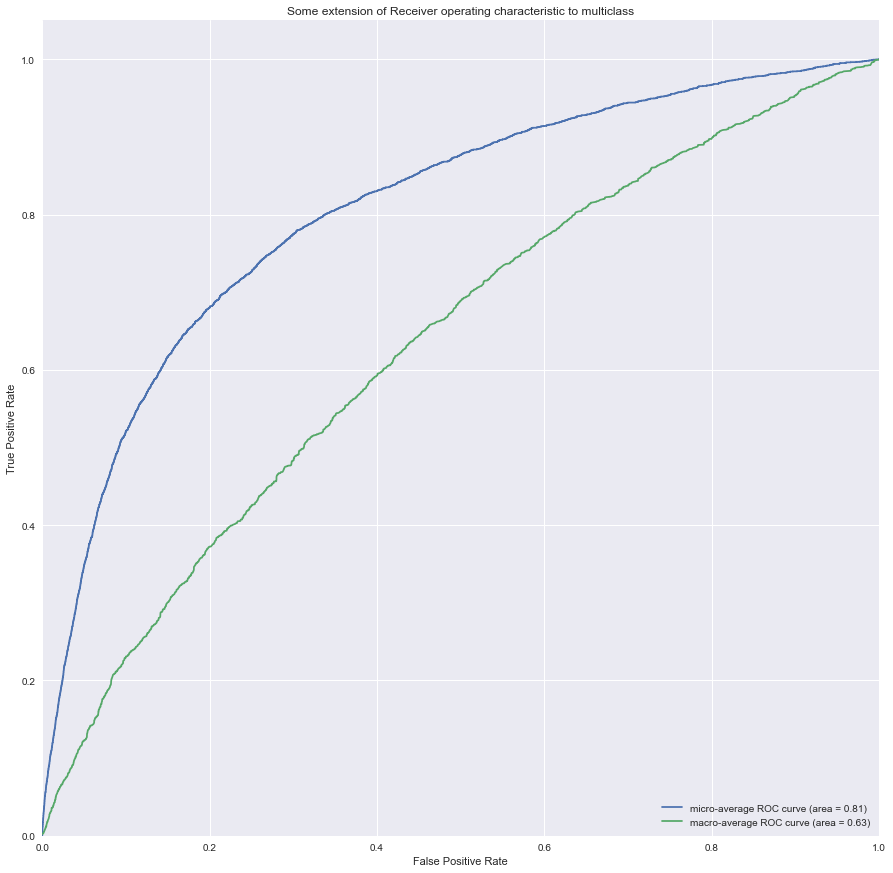

In [252]:
model.plot_roc('lda gensim')

In [168]:
tags_binarizer.classes_[score > 13]

array(['java', 'javascript', 'php'], dtype=object)

In [164]:
tags_binarizer.classes_[y_test[0] == 1]

array(['php', 'wordpress'], dtype=object)

In [133]:
ldaTags_gensim[(test > 0.15)[0]]

array(['got', 'solution', 'solution', 'instead'], dtype='<U9')

In [122]:
test = np.array(best_lda.get_document_topics(corpus_test, minimum_probability=0))[:,:,1]

In [100]:
topic_tag

0         1         2         3         4         5         6   \
0   0.001549  0.428418  0.725611  0.046192  1.478234  0.005125  0.154925   
1   0.001549  0.015544  0.272740  0.092844  1.355119  0.005125  0.014698   
2   0.001549  0.015544  0.016631  0.007470  0.861549  0.005125  0.014698   
3   0.001549  0.305963  0.548213  0.375067  1.040085  0.005125  0.159024   
4   0.001549  0.015544  0.016631  0.007470  1.262921  0.005125  0.014698   
5   0.001549  0.244305  0.053881  0.063204  0.789944  0.005125  0.014698   
6   0.001549  0.354381  0.016631  0.007470  0.854498  0.005125  0.775212   
7   0.001549  0.077615  0.860792  0.007470  1.714494  0.005125  0.975806   
8   0.222853  0.763728  0.094514  0.007470  1.733439  0.378122  1.198499   
9   0.001549  0.015544  0.697804  0.044325  1.492639  0.427054  0.014698   
10  0.232472  0.530142  0.910696  0.439129  3.605813  0.005125  0.014698   
11  0.001549  0.079137  0.332179  0.114640  1.033704  0.170630  0.014698   
12  0.001549  0.341231  0.091242  0.096904  1.621411  0.005125  0.014698   
13  0.001549  0.015544  0.127878  0.052713  1.447434  0.005125  0.256309   
14  0.001549  0.015544  0.016631  0.312653  1.468107  0.005125  0.341675   
15  0.066878  0.245285  0.212927  0.804399  3.552846  0.005125  0.313771   
16  0.001549  0.015544  0.625724  0.329854  2.273015  0.005125  0.014698   
17  0.675536  0.445097  1.574613  0.007470  2.601064  0.005125  0.314294   
18  0.001549  0.015544  0.214875  0.183503  1.592836  0.005125  0.227764   
19  0.001549  0.247204  0.352142  0.354859  2.681200  0.393644  0.014698   
20  0.001549  0.015544  0.555706  0.007470  1.956387  0.005125  0.128529   
21  0.001549  0.067026  0.016631  0.203232  2.122653  0.005125  0.899022   
22  0.001549  0.135449  0.183535  0.007470  0.804114  0.005125  0.014698   
23  0.001549  0.743276  0.190994  0.125195  0.440561  0.005125  0.119953   
24  0.001549  0.733658  0.016631  0.007470  3.836539  0.005125  0.412537   
..       ...       ...       ...       ...       ...       ...       ...   
75  0.001549  0.081825  0.242365  0.007470  0.582489  0.005125  0.420735   
76  0.001549  0.087398  0.165593  0.624191  1.954975  0.005125  0.014698   
77  0.001549  0.015544  0.016631  0.777735  2.302136  0.230258  0.014698   
78  0.001549  1.068758  0.455026  0.178252  2.413294  0.005125  0.264054   
79  0.258995  0.191853  1.029615  0.621173  2.690895  0.005125  0.014698   
80  0.001549  0.300539  0.016631  0.133839  4.431087  0.439293  0.059613   
81  0.001549  0.884902  0.208040  0.683413  1.537062  0.005125  0.143844   
82  0.001549  0.015544  0.359152  0.193187  2.366853  0.005125  0.079916   
83  0.115430  0.015544  0.493183  0.175130  1.830033  0.005125  0.134007   
84  0.001549  0.536025  1.353733  0.197684  6.000078  0.005125  0.914674   
85  0.001549  0.233388  0.016631  0.110543  2.924409  0.282189  0.339661   
86  0.140836  0.676357  0.524340  0.007470  2.338927  0.005125  1.252865   
87  0.001549  0.015544  0.598266  0.007470  5.786222  0.005125  1.533829   
88  0.001549  0.187036  0.569727  0.507721  2.273983  0.005125  0.121289   
89  0.001549  0.015544  0.253834  0.007470  0.927816  0.005125  0.014698   
90  0.001549  0.747492  0.285622  0.380306  1.729609  0.005125  0.383130   
91  0.001549  0.520848  0.108927  0.100590  1.079815  0.005125  0.799956   
92  0.001549  0.118797  0.083992  0.345936  2.987383  0.250927  0.132425   
93  0.001549  0.082597  0.016631  0.192692  1.168415  0.005125  0.315535   
94  0.001549  0.080644  0.078805  0.007470  1.460745  0.005125  0.820482   
95  0.001549  0.317767  0.062659  0.406510  0.928403  0.005125  0.014698   
96  0.001549  0.015544  0.016631  0.226371  0.849554  0.005125  0.166880   
97  0.001549  1.215102  0.091031  0.067022  1.291078  0.005125  0.102252   
98  0.001549  1.276913  0.016631  0.007470  2.067372  0.005125  0.390222   
99  0.001549  0.015544  0.178643  0.088392  0.832009  0.005125  0.328371   

          7         8         9         10        11     

In [15]:
gensimvis.prepare(best_lda, corpus, dico)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.009519 -0.007455       1        1  1.903660
0      0.004461  0.005667       2        1  1.715571
24     0.026879 -0.009663       3        1  1.531565
90    -0.005254  0.013278       4        1  1.457016
72     0.005854 -0.000767       5        1  1.443792
63     0.019564 -0.011612       6        1  1.437838
57     0.000502 -0.005768       7        1  1.411396
28     0.008631 -0.017758       8        1  1.404251
70     0.028387 -0.000824       9        1  1.356352
59     0.030950  0.008486      10        1  1.329601
50     0.003574  0.001430      11        1  1.318012
18     0.017478 -0.001614      12        1  1.295596
30     0.008039 -0.005213      13        1  1.294444
36     0.040323 -0.015702      14        1  1.281301
96     0.001696  0.018061      15        1  1.277946
15    -0.010078 -0.000774      16        1  1.256409
75    -0.020400  0.004579      17        1  1.217811
99    -0.008523  0.017350      18        1  1.198194
76     0.010500  0.021847      19        1  1.195643
82     0.024393  0.023934      20        1  1.193030
79    -0.007576 -0.028310      21        1  1.189433
51     0.010003 -0.007547      22        1  1.189217
77     0.024517  0.024384      23        1  1.188332
69     0.023461  0.019477      24        1  1.186820
20    -0.017741  0.006023      25        1  1.174789
...         ...       ...     ...      ...       ...
66    -0.035884  0.007121      76        1  0.806921
78    -0.006584  0.033632      77        1  0.791296
32     0.003714 -0.008476      78        1  0.789680
65     0.037626  0.031393      79        1  0.784956
23     0.000796  0.003520      80        1  0.784352
33    -0.005385  0.065510      81        1  0.777528
73    -0.018330  0.042169      82        1  0.773581
88     0.013198  0.035400      83        1  0.771761
29     0.005121 -0.012771      84        1  0.770821
49    -0.003301 -0.004234      85        1  0.767470
64    -0.066581 -0.044960      86        1  0.766580
95     0.029487  0.024315      87        1  0.765045
7      0.009004 -0.021417      88        1  0.759022
8      0.045086 -0.058878      89        1  0.752888
89     0.002725 -0.020525      90        1  0.713520
53    -0.063886  0.056005      91        1  0.693719
87    -0.028119 -0.010226      92        1  0.688917
21    -0.013843 -0.003490      93        1  0.679572
74    -0.026261  0.055472      94        1  0.673260
55     0.001914  0.066292      95        1  0.672354
60    -0.088321  0.077975      96        1  0.649134
31    -0.052348 -0.039432      97        1  0.624291
13     0.045676 -0.051988      98        1  0.621847
38    -0.082081 -0.098757      99        1  0.601687
37    -0.097138  0.021274     100        1  0.590606

[100 rows x 5 columns], topic_info=            Term        Freq       Total  Category  logprob  loglift
263        right  501.000000  501.000000   Default  30.0000  30.0000
22           got  386.000000  386.000000   Default  29.0000  29.0000
730   javascript  376.000000  376.000000   Default  28.0000  28.0000
336         idea  637.000000  637.000000   Default  27.0000  27.0000
1171       thank  367.000000  367.000000   Default  26.0000  26.0000
438         much  321.000000  321.000000   Default  25.0000  25.0000
411          say  451.000000  451.000000   Default  24.0000  24.0000
42       default  214.000000  214.000000   Default  23.0000  23.0000
72       without  542.000000  542.000000   Default  22.0000  22.0000
113   understand  296.000000  296.000000   Default  21.0000  21.0000
66          give  447.000000  447.000000   Default  20.0000  20.0000
55      possible  565.000000  565.000000   Default  19.0000  19.0000
591         item  273.000000  273.000000   Default  18.0000  18.0000
123      instead  391.000000  391.000000   Default  17.0000  17.0000
178         fine  570.000000  570.000000   Default  16.0000  16.0000
634      element  36

### LDA Sklearn

In [10]:
lda = LatentDirichletAllocation(
    n_components=100, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=100, n_jobs=-1)

In [32]:
lda.components_.argmax(axis=1).shape

(100,)

In [30]:
vocabulary.shape

(9923,)

In [33]:
ldaTags = np.vectorize(lambda x: vocabulary[x])(lda.components_.argmax(axis=1))

In [49]:
ldaTags[(lda.transform(x_test_counts) > 0.15)[5]]

array(['chrome'], dtype='<U11')

In [38]:
y_test[0] == 1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False])

In [48]:
tags_binarizer.classes_[y_test[5] == 1]

array(['html', 'javascript'], dtype=object)

In [35]:
np.vectorize(lambda x: vocabulary[x])(lda.components_.argmax(axis=1))

array(['facebook', 'print', 'package', 'end', 'command', 'div', 'event',
       'implicit', 'read', 'thread', 'record', 'script', 'window', 'key',
       'field', 'keyboard', 'dictionary', 'argument', 'index', 'replace',
       'parameter', 'jar', 'int', 'header', 'property', 'browser', 'r',
       'assembly', 'device', 'item', 'statement', 'arraylist', 'ftp',
       'hover', 'service', 'video', 'element', 'message', 'dropdown',
       'visual', 'space', 'x', 'java', 'sort', 'dialog', 'ajax', 'row',
       'link', 'output', 'wrong', 'directory', 'vector', 'chrome', 'loop',
       'element', 'login', 'activity', 'photo', 'bar', 'tag',
       'navigation', 'select', 'colour', 'block', 'grid', 'cell',
       'relation', 'map', 'date', 'product', 'title', 'virtual', 'test',
       'reference', 'back', 'window', 'ran', 'store', 'controller',
       'submit', 'fragment', 'icon', 'graph', 'library', 'control',
       'request', 'size', 'jquery', 'json', 'undefined', 'url', 'token',
       'ch

In [9]:
LDAsklearn.prepare(lda, x_train_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.242712  0.078224       1        1  2.326929
87     0.145387  0.091163       2        1  1.999205
42    -0.117899  0.145651       3        1  1.895073
14     0.104680 -0.046933       4        1  1.882301
78     0.029111  0.010262       5        1  1.675411
68    -0.016866 -0.146908       6        1  1.666932
86     0.159366  0.007981       7        1  1.541774
46     0.034686 -0.119898       8        1  1.514749
10     0.011252 -0.091977       9        1  1.481246
93     0.001287  0.014664      10        1  1.455109
92    -0.029538 -0.148216      11        1  1.417057
50    -0.025909  0.086656      12        1  1.396925
97    -0.017806 -0.007242      13        1  1.320561
25     0.138636  0.141432      14        1  1.299416
37    -0.057356  0.026696      15        1  1.283326
11    -0.074324 -0.002514      16        1  1.244251
88    -0.063286  0.012848      17        1  1.236896
89    -0.044609 -0.015239      18        1  1.229708
98    -0.000975  0.035700      19        1  1.225875
17    -0.081162 -0.019743      20        1  1.205622
72    -0.041257 -0.055578      21        1  1.198928
74     0.031511  0.038655      22        1  1.189719
85    -0.021194  0.080029      23        1  1.187117
53    -0.057842  0.011060      24        1  1.184774
29     0.168632 -0.046553      25        1  1.179213
...         ...       ...     ...      ...       ...
79    -0.016187 -0.004164      76        1  0.778507
69    -0.022462 -0.034497      77        1  0.778161
65     0.094888 -0.005817      78        1  0.776433
34     0.003193  0.091096      79        1  0.773600
81     0.013519 -0.002834      80        1  0.767810
22     0.003266 -0.046309      81        1  0.742174
16    -0.041875 -0.013600      82        1  0.728906
66     0.037152 -0.028311      83        1  0.728504
19     0.022441 -0.066494      84        1  0.725405
91    -0.054446 -0.010287      85        1  0.724623
57     0.045972  0.029676      86        1  0.716100
44     0.038953 -0.014240      87        1  0.712935
27    -0.042730 -0.008423      88        1  0.711881
95    -0.013316  0.037744      89        1  0.702167
60     0.005642  0.003319      90        1  0.691227
31    -0.006166 -0.018534      91        1  0.676368
70     0.000993 -0.054725      92        1  0.671228
15    -0.008549  0.014918      93        1  0.647645
47     0.001940  0.071793      94        1  0.640705
76    -0.007404  0.023431      95        1  0.633315
54     0.036179 -0.035260      96        1  0.627795
71     0.014447 -0.017454      97        1  0.626284
7     -0.031704 -0.025827      98        1  0.615692
12    -0.018805  0.056209      99        1  0.613272
62     0.038378 -0.031127     100        1  0.519601

[100 rows x 5 columns], topic_info=            Term        Freq       Total  Category  logprob  loglift
3            row  702.000000  702.000000   Default  30.0000  30.0000
30          test  554.000000  554.000000   Default  29.0000  29.0000
2         jquery  679.000000  679.000000   Default  28.0000  28.0000
15         field  622.000000  622.000000   Default  27.0000  27.0000
31          item  536.000000  536.000000   Default  26.0000  26.0000
84          json  456.000000  456.000000   Default  25.0000  25.0000
62          date  483.000000  483.000000   Default  24.0000  24.0000
17    javascript  662.000000  662.000000   Default  23.0000  23.0000
76        select  429.000000  429.000000   Default  22.0000  22.0000
37       message  586.000000  586.000000   Default  21.0000  21.0000
93           xml  414.000000  414.000000   Default  20.0000  20.0000
44            id  496.000000  496.000000   Default  19.0000  19.0000
57    controller  487.000000  487.000000   Default  18.0000  18.0000
51         event  501.000000  501.000000   Default  17.0000  17.0000
79           key  428.000000  428.000000   Default  16.0000  16.0000
81       service  35

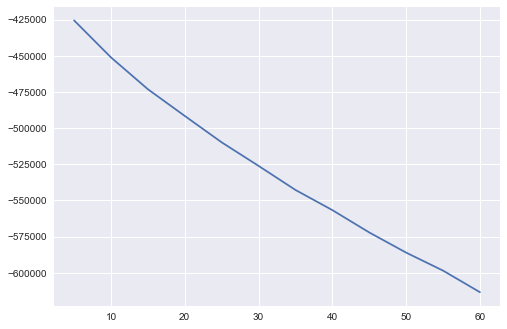

In [53]:
plt.plot(params["n_components"], grid.cv_results_["mean_test_score"])

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(x_test_counts))


# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(x_test_counts))

Log Likelihood:  -96303.1400915431
Perplexity:  101999.2257173945


### NMF Sklearn

In [ ]:
# Run NMF
nmf = NMF(n_components=30, random_state=129)
nmf.fit(x_train_counts)
x_nmf = nmf.transform(x_train_counts)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=30, random_state=129)

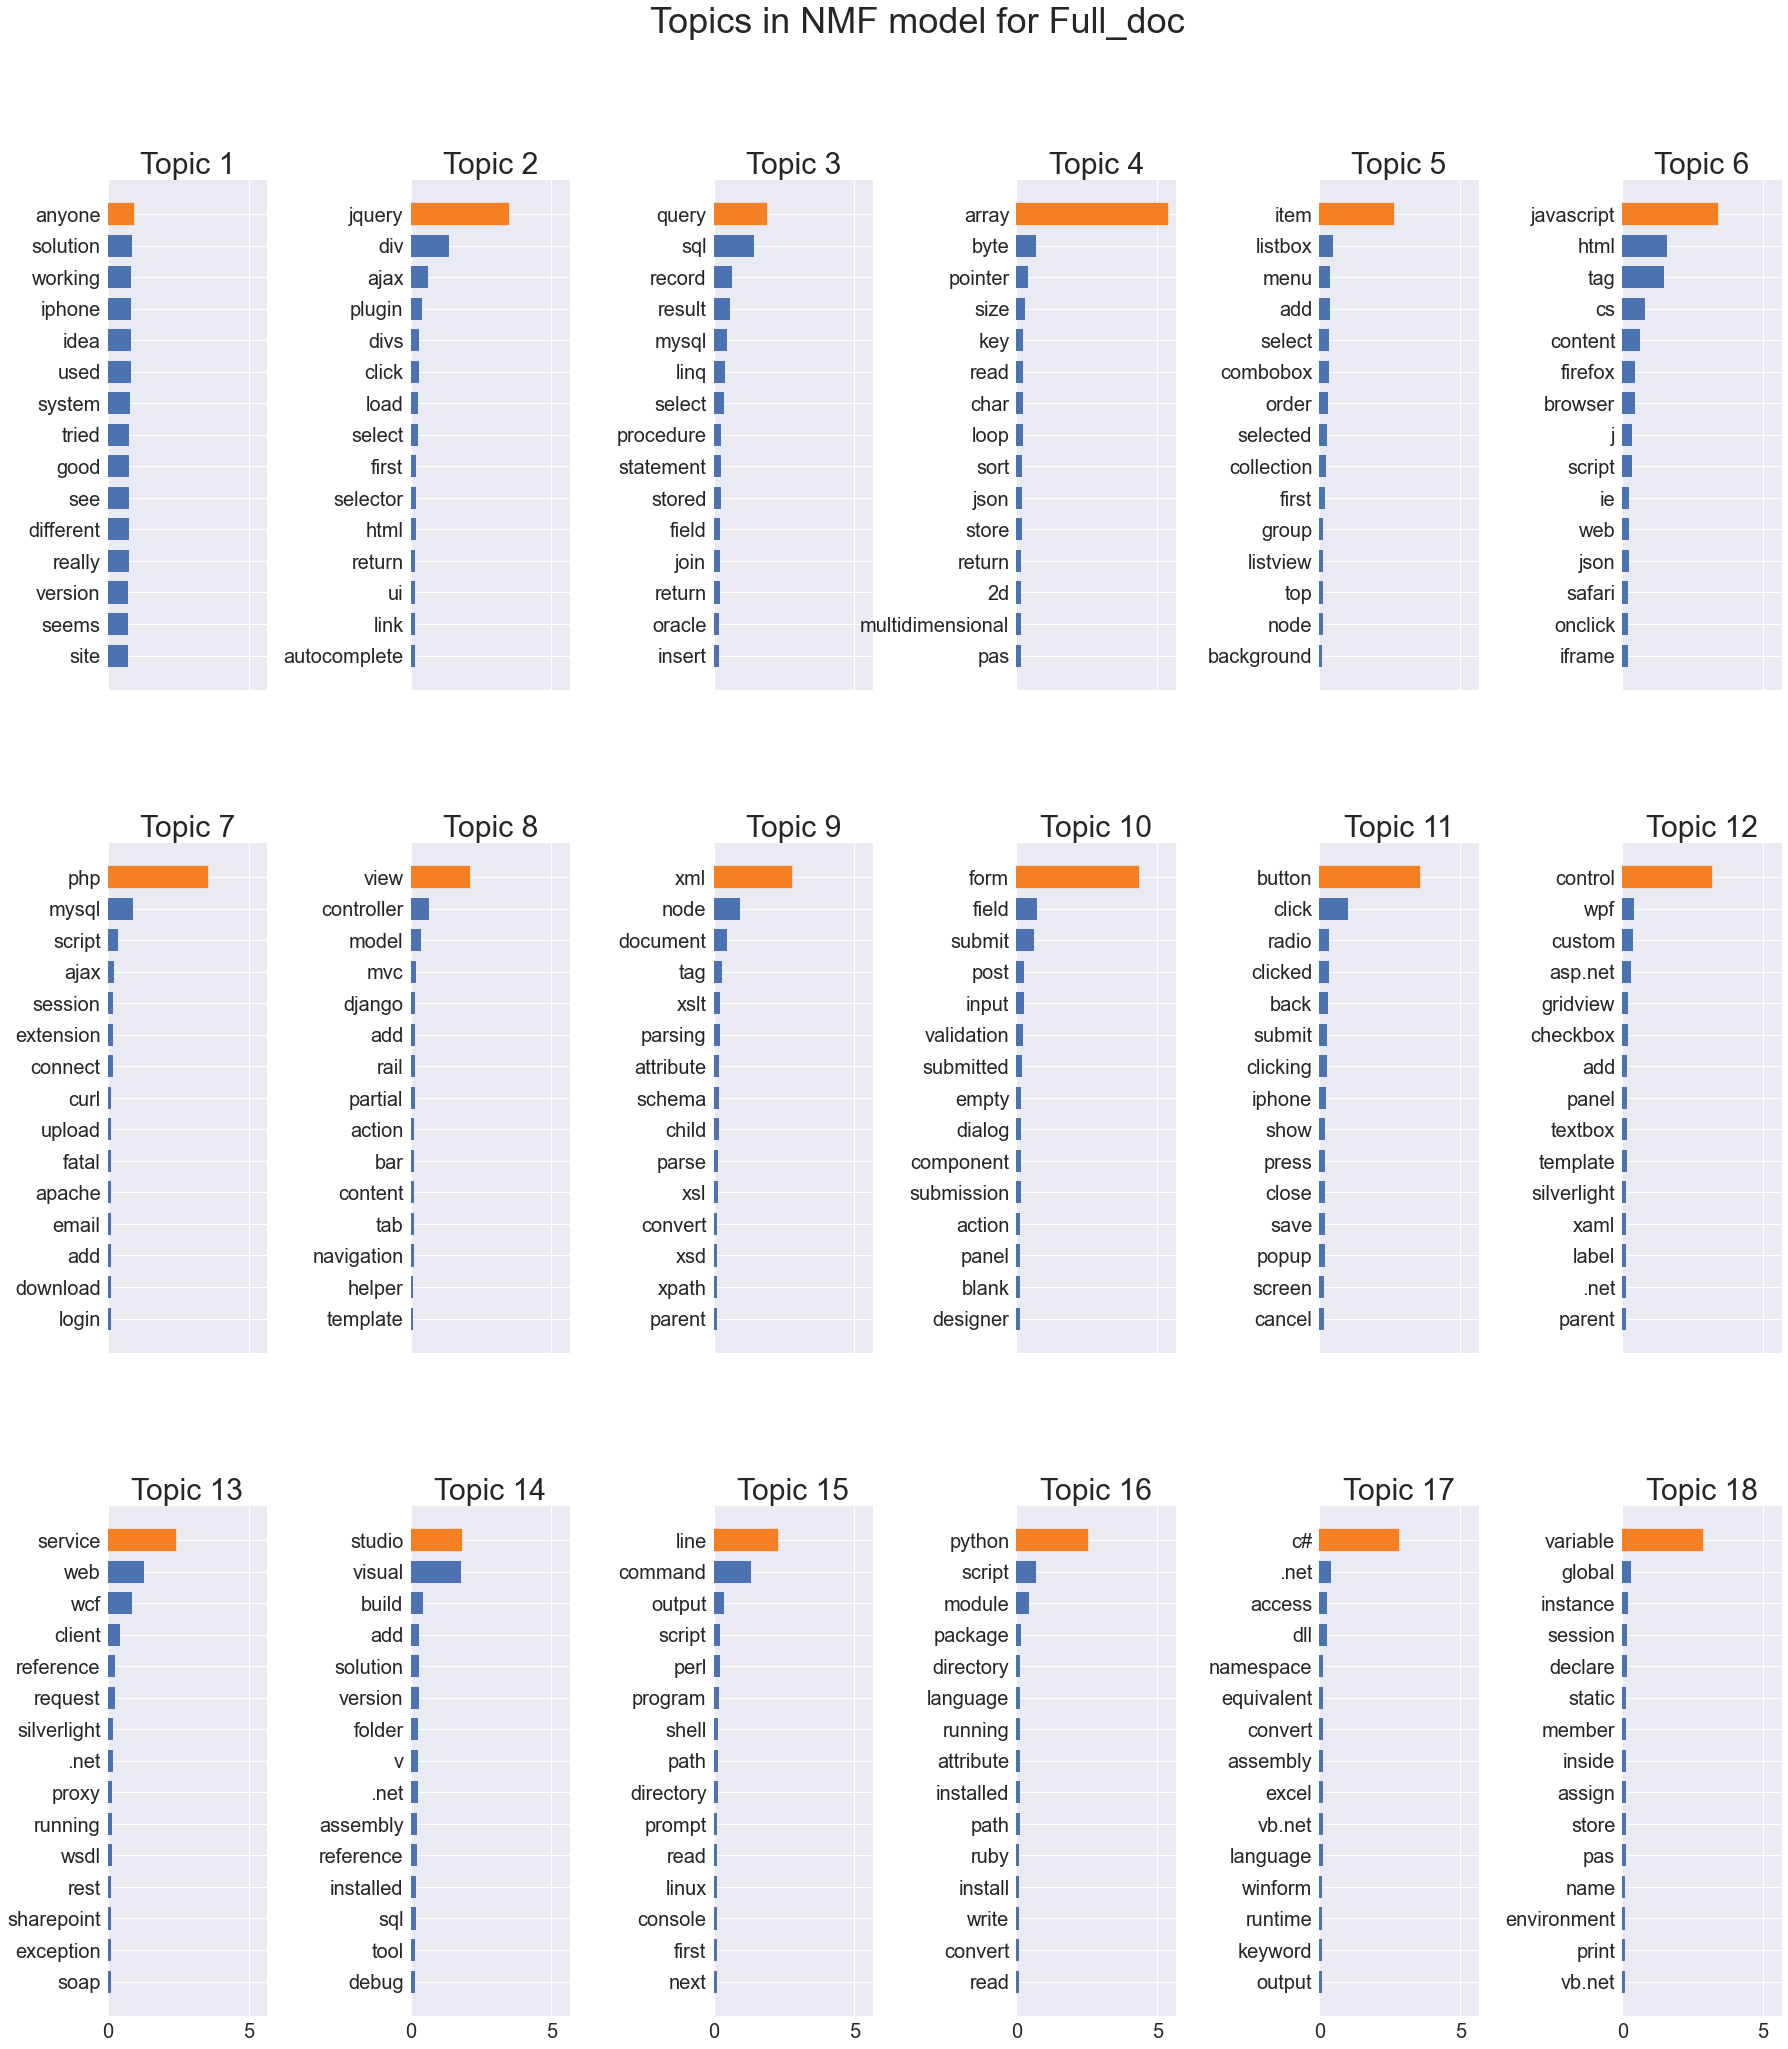

In [ ]:
# Initializing the NMF
full_nmf = NMF(n_components=30, init="nndsvda", random_state=129)

# Fit NMF on Body vectorized
full_nmf.fit(x_train_tfidf)

# Plot the 12 first topics
ff_feature_names = count_vect.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 15, 3,
               'Topics in NMF model for Full_doc')